# Analyis of the Simple Model Results

**Authorship:**
Adam Klie, *05/04/2022*
***
**Description:**
Notebook to do some cool stuff
***
<div class="alert alert-block alert-warning">
<b>TODOs</b>:
<ul>
    <b><li></li></b>
    <b><li></li></b>
    <b><li></li></b>
    </ul>
</div>

# Set-up

In [2]:
# The classics
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.style.use("presentation")

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

# Performance Analysis

## Netron visualization of a model

In [31]:
import torch
from eugene.models.hybrid import hybrid

In [34]:
CKT_PTH  = "/cellar/users/aklie/projects/EUGENE/results/simple/classification/dshybrid/2022_04_23_NPY_Baseline/checkpoints/epoch=11-step=2087.ckpt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
eugene = hybrid.load_from_checkpoint(
    checkpoint_path=CKT_PTH,
    map_location=device,
)

/cellar/users/aklie/opt/miniconda3/envs/pytorch_dev/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [38]:
from torchvision import transforms
from eugene.utils.seq_transforms import ReverseComplement, Augment, OneHotEncode, ToTensor
from eugene.dataloading.SeqDataModule import SeqDataModule

In [39]:
data_transform = transforms.Compose([
    Augment(randomize_linker_p=0.1, enhancer="WT-otx-a"), 
    ReverseComplement(ohe_encoded=False), 
    OneHotEncode(), 
    ToTensor(transpose=True)
])

In [42]:
DATA_DIR = "../test/test_{}seqs_{}/".format(100, 66)
mod = SeqDataModule(seq_file=DATA_DIR + "test_seqs.tsv",
                    transform=data_transform,
                    num_workers=4,
                    batch_size=32,
                    test= True,
                    load_kwargs=dict(seq_col="SEQ", name_col="NAME", target_col="LABEL"))
mod.setup()
batch = next(iter(mod.test_dataloader()))

In [52]:
input_names = ['Forward Sequence', 'Reverse Complement Sequence']
output_names = ['Enhancer Activity']
torch.onnx.export(eugene, (batch[1], batch[2]), '../results/simple/classification/summary/dshybrid.onnx', input_names=input_names, output_names=output_names)

## Hyperparameters of the model

In [4]:
performance_tbl = pd.read_csv("../../results/simple/regression/summary/hparams_table.csv")
model_types = ["CNN", "FCN", "hybrid", "RNN"]*3
performance_tbl["model_type"] = model_types
performance_tbl["model"] = performance_tbl["strand"] + performance_tbl["model_type"]
performance_tbl.head()

,input_len,strand,task,aggr,fc_kwargs/hidden_dims,fc_kwargs/dropout_rate,fc_kwargs/batchnorm,fc_kwargs/output_dim,hp_metric,model_type,model
0,66.0,ds,regression,None,[1536],0.2,1.0,1.0,0.136644,CNN,dsCNN
1,66.0,ds,regression,None,"[256, 128]",0.2,1.0,1.0,0.148430,FCN,dsFCN
2,66.0,ds,regression,None,[32],0.2,1.0,1.0,0.176156,hybrid,dshybrid
3,66.0,ds,regression,None,[64],0.2,1.0,1.0,0.152171,RNN,dsRNN
4,66.0,ss,regression,None,[768],0.2,1.0,1.0,0.178289,CNN,ssCNN


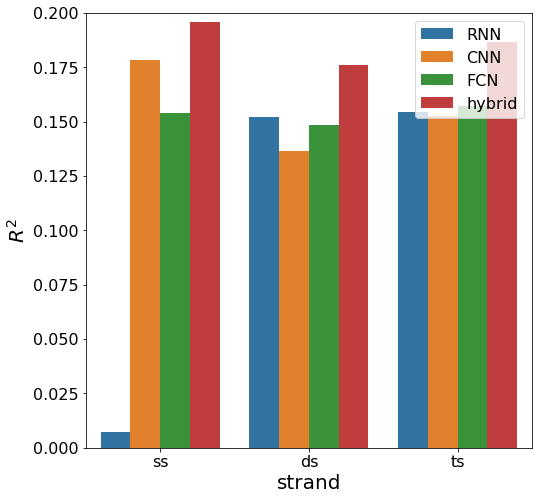

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
sns.barplot(data=performance_tbl.sort_values("hp_metric"), x="strand", y="hp_metric", hue="model_type")
ax.set_ylim(0, 0.2)
ax.set_ylabel(r'$R^2$')
#ax.set_ylabel("AUROC")
plt.legend(loc="upper right");

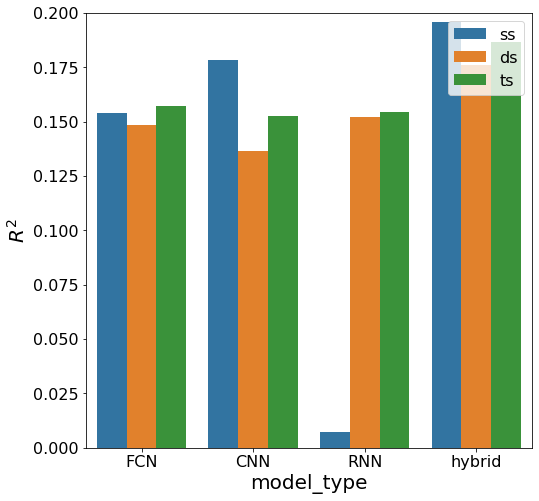

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
sns.barplot(data=performance_tbl, x="model_type", y="hp_metric", hue="strand", order=["FCN", "CNN", "RNN", "hybrid"], hue_order=["ss", "ds", "ts"])
ax.set_ylim(0, 0.2)
ax.set_ylabel(r'$R^2$')
#ax.set_ylabel("AUROC")
plt.legend(loc="upper right");

# Predictions Analysis

In [66]:
preds = pd.read_csv("../results/simple/classification/sshybrid/2022_04_23_NPY_Baseline/predictions/2021_OLS_Holdout_predictions.tsv", sep="\t")
preds.head()

,NAME,PREDICTION,TARGET
0,S1-G1R-S2-E1F-S3-E2F-S4-G2R-S5-G3F-S6,2.161896,0.611767
1,S1-G1F-S2-E1F-S3-E2F-S4-G2R-S5-G3F-S6,0.654459,0.313011
2,S1-G1R-S2-E1F-S3-E2F-S4-G2F-S5-G3F-S6,1.360202,0.387121
3,S1-G1R-S2-E1R-S3-E2F-S4-G2R-S5-G3F-S6,2.985420,0.250995
4,S1-G1R-S2-E1F-S3-E2R-S4-G2R-S5-G3F-S6,0.387980,0.319106


In [310]:
metadata = pd.read_csv("../data/2021_OLS_Library/2021_OLS_Library.tsv", sep="\t", low_memory=False)
validated_seqs = metadata[~metadata["MICROSCOPE_FXN"].isna()]
validated_preds = pd.merge(preds, validated_seqs[["NAME", "SEQ", "MICROSCOPE_FXN"]], on="NAME")
validated_preds["VALIDATED_LABEL"] = (~(validated_preds["MICROSCOPE_FXN"] == "Non-Functional")).astype(int)
validated_preds["PREDICTED_LABEL"] = (validated_preds["PREDICTION"] >= 0).astype(int) 
validated_preds.head()

,NAME,PREDICTION,TARGET,SEQ,MICROSCOPE_FXN,VALIDATED_LABEL,PREDICTED_LABEL
0,S1-G1R-S2-E1F-S3-E2F-S4-G2R-S5-G3F-S6,2.161896,0.611767,CATCTGAAGCTCGTTATCTCTAACGGAAGTTTTCGAAAAGGAAATT...,Neural Enhancer,1,1
1,S3-G1R-S2-E1R-S5-E2R-S4-G2R-S1-G3R-S6,-0.939022,0.327604,TTTCGAAGTTATCTCTAACTTCCGTATTTCCTTTGCTCAATATCTC...,Weak Neural Enhancer,1,0
2,S1-G1R-S4-E1F-S3-G2R-S5-G3F-S2-E2F-S6,0.509338,1.191300,CATCTGAAGCTCGTTATCTCTGCTCACGGAAGTTTTCGAAAATATC...,Neural Enhancer,1,1
3,S5-G1F-S1-E2R-S3-E1F-S4-G3F-S2-G2R-S6,-0.391599,0.400540,GAGATAACCATCTGAAGCTCATTTCCTTTTTCGAAACGGAAGTTGC...,Neural + Ectopic Expression,1,0
4,S1-G1R-S5-E2R-S2-G2F-S4-E1R-S3-G3R-S6,4.701243,1.687609,CATCTGAAGCTCGTTATCTCATTTCCTTTAAGATATTTGCTCACTT...,Neural + Ectopic Expression,1,1


/cellar/users/aklie/opt/miniconda3/envs/pytorch_dev/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 23.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


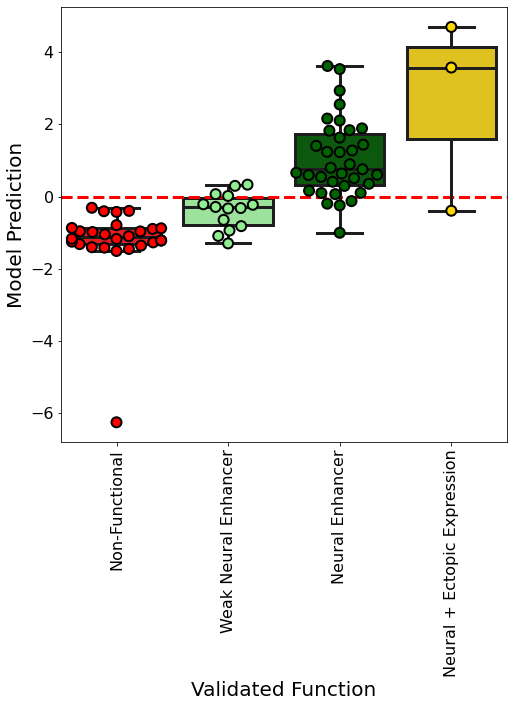

In [85]:
validated_pred_colors = dict(zip(validated_preds["MICROSCOPE_FXN"].unique(), ["darkgreen", "lightgreen", "gold", "red"]))
order = ['Non-Functional', 'Weak Neural Enhancer', 'Neural Enhancer', 'Neural + Ectopic Expression']

fig, ax = plt.subplots(1, 1, figsize=(8,8))
sns.boxplot(y=validated_preds["PREDICTION"], x=validated_preds["MICROSCOPE_FXN"], order=order, palette=validated_pred_colors, ax=ax)
sns.swarmplot(y=validated_preds["PREDICTION"], x=validated_preds["MICROSCOPE_FXN"], order=order, palette=validated_pred_colors, size=10, edgecolor="black", linewidth=2, ax=ax)
ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], color="red", linestyle="dashed")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=16);
ax.set_xlabel("Validated Function", fontsize=20)
ax.set_ylabel("Model Prediction", fontsize=20);

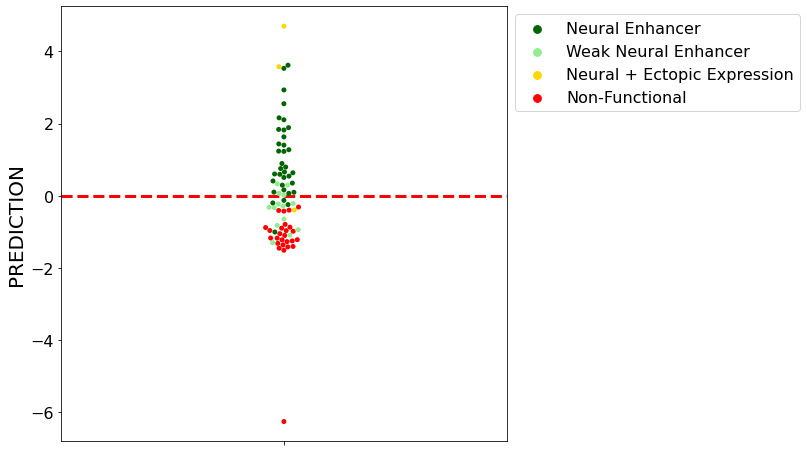

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
sns.swarmplot(y=validated_preds["PREDICTION"], hue=validated_preds["MICROSCOPE_FXN"], x=[""]*len(validated_preds), palette=validated_pred_colors, ax=ax)
plt.legend(bbox_to_anchor=(1,1))
ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], color="red", linestyle="dashed");

In [86]:
from eugene.utils.plotting import cf_plot_from_df

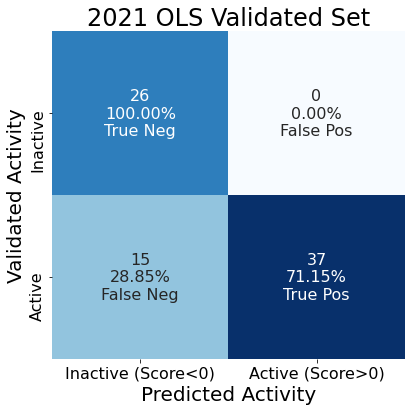

In [96]:
cf_plot_from_df(validated_preds, label_col="VALIDATED_LABEL", pred_col="PREDICTED_LABEL", title="2021 OLS Validated Set", ylab="Validated Activity", threshold=0)

# Interpetations Analysis

## Nucleotide Importances

In [125]:
from eugene.utils.otx_enhancer_utils import otxGenomeTracks

In [126]:
nt_imps = np.load("../results/simple/classification/sshybrid/2022_04_23_NPY_Baseline/interpretations/2021_OLS_Libarary_Holdout/nt_importances.npy")
seqs = np.loadtxt("../data/2021_OLS_Library/seqs/0.09-0.4_seqs-holdout.txt", dtype=str)
ids = np.loadtxt("../data/2021_OLS_Library/id/0.09-0.4_id-holdout.txt", dtype=str)
names = preds["NAME"].values
predictions = preds["PREDICTION"]

In [127]:
# Visualize the first example
cmap = matplotlib.cm.RdYlGn
norm = matplotlib.colors.Normalize(vmin=np.min(predictions), vmax=np.max(predictions))
max_idx = np.argmax(predictions)
min_idx = np.argmin(predictions)

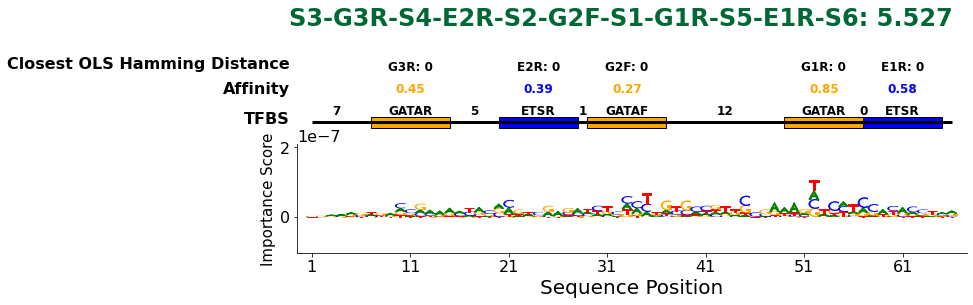

In [128]:
# Check the max prediction sequence
otxGenomeTracks(seqs[max_idx], 
                importance_scores=nt_imps[max_idx], 
                model_pred = predictions[max_idx],
                seq_name=names[max_idx], 
                cmap=cmap, 
                norm=norm)

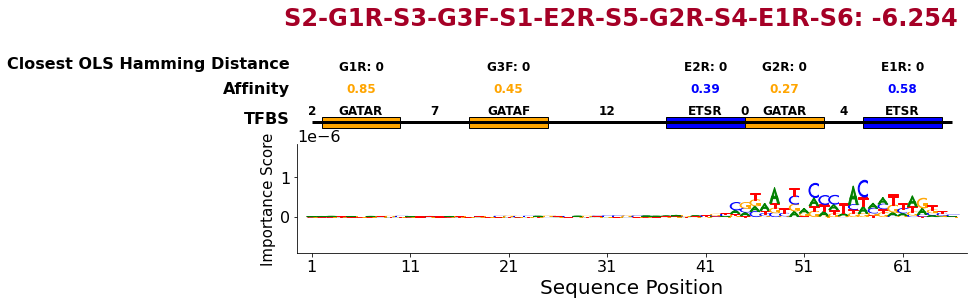

In [129]:
# Check the min prediction sequence
max_idx = np.argmax(predictions)
otxGenomeTracks(seqs[min_idx], 
                importance_scores=nt_imps[min_idx], 
                model_pred = predictions[min_idx],
                seq_name=names[min_idx], 
                cmap=cmap, 
                norm=norm)

In [130]:
from eugene.utils.otx_enhancer_utils import loadSiteName2bindingSiteSequence

In [134]:
feature_defs = loadSiteName2bindingSiteSequence()

In [141]:
nt_imp_sum = nt_imps.sum(axis=1)
nt_imp_sum.shape

(263252, 66)

In [143]:
feature_defs

{'S1': 'CATCTGAAGCTC',
 'G1R': 'GTTATCTC',
 'S2': 'TA',
 'E1F': 'ACGGAAGT',
 'S3': 'TTTCGAA',
 'E2F': 'AAGGAAAT',
 'S4': 'TGCTC',
 'G2R': 'AATATCT',
 'S5': '',
 'G3F': 'AAGATAGG',
 'G1F': 'GAGATAAC',
 'E1R': 'ACTTCCGT',
 'E2R': 'ATTTCCTT',
 'G2F': 'AGATATT',
 'G3R': 'CCTATCTT',
 'S6': 'A'}

In [339]:
feature_vec_len = len(names[0].split("-"))
feature_vec = np.zeros((len(names), feature_vec_len))
feature_dict = dict(zip(feature_defs.keys(), np.empty((len(feature_defs), len(names)))))
for i, (name, imp) in tqdm.tqdm(enumerate(zip(names, nt_imp_sum))):
    start = 0
    for j, feature in enumerate(name.split("-")):
        feature_len = len(feature_defs[feature])
        feature_sum = np.sum(imp[start:start+feature_len])
        feature_vec[i, j] = feature_sum/feature_len
        feature_dict[feature][i] = feature_sum/feature_len
        start = start+feature_len

0it [00:00, ?it/s]/cellar/users/aklie/opt/miniconda3/envs/pytorch_dev/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/cellar/users/aklie/opt/miniconda3/envs/pytorch_dev/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
263252it [00:15, 16726.78it/s]


In [340]:
agg_feature_importances = pd.DataFrame(index=names, data=feature_dict)
agg_feature_importances.drop("S5", axis=1, inplace=True)
scaled_agg_imp = (agg_feature_importances - agg_feature_importances.mean(axis=0))/(agg_feature_importances.std(axis=0))

In [341]:
from eugene.utils.utils import make_skree_plot, pca_plot

In [342]:
from sklearn.decomposition import PCA

In [343]:
# Run PCA
pca = PCA(n_components=15)
pca.fit(scaled_agg_imp)
pca_df = pd.DataFrame(pca.fit_transform(scaled_agg_imp))
pca_df.columns = ['PC' + str(col+1) for col in pca_df.columns]
pca_df.index = scaled_agg_imp.index
pca_df.index.name = "NAME"
pca_embedding = pca_df.values

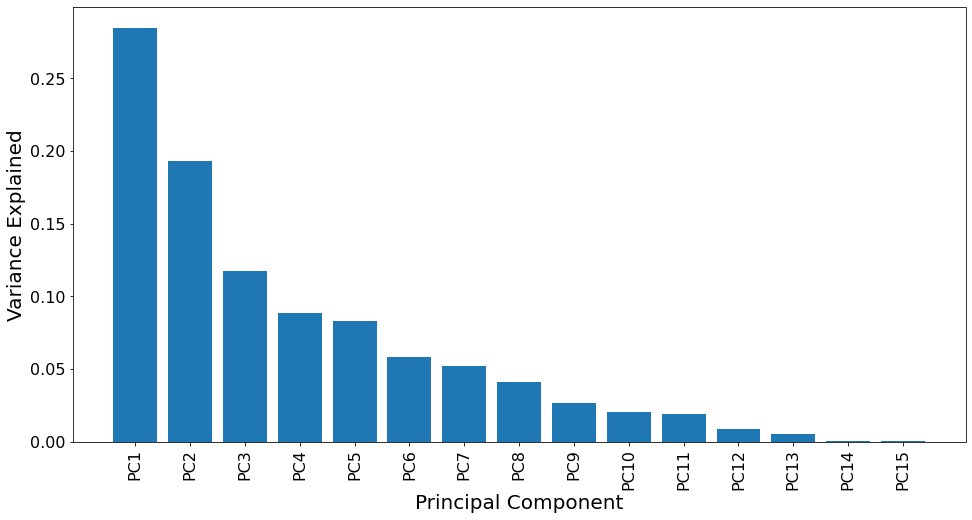

In [344]:
pc_var_explained = make_skree_plot(pca, n_comp=15)

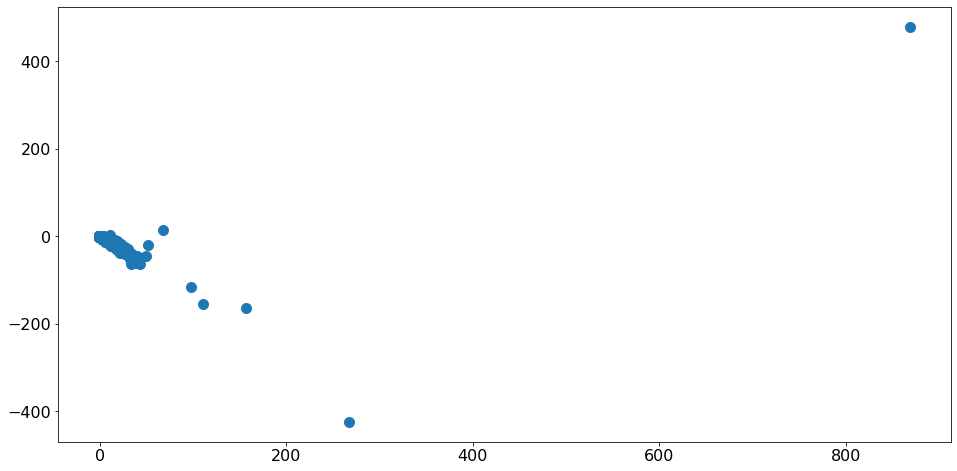

In [345]:
xs = pca_embedding[:, 0]
ys = pca_embedding[:, 1]
ax = plt.scatter(xs, ys)

In [346]:
outlier = pca_df[pca_df["PC1"] > 800].index[0]

In [347]:
agg_feature_importances.loc[outlier]

S1     2.309119e-05
G1R    1.055157e-04
S2     6.020725e-07
E1F    3.634946e-07
S3     6.230897e-07
E2F    0.000000e+00
S4     7.718209e-05
G2R    0.000000e+00
G3F    0.000000e+00
G1F    0.000000e+00
E1R    0.000000e+00
E2R    4.751968e-07
G2F    9.829744e-05
G3R    2.203245e-06
S6     9.385733e-08
Name: S4-G1R-S5-G2F-S1-G3R-S2-E2R-S3-E1F-S6, dtype: float64

In [348]:
scaled_agg_imp.loc[outlier]

S1     468.010329
G1R    508.501126
S2      10.208667
E1F      8.331811
S3      23.026928
E2F     -0.529688
S4     498.620382
G2R     -0.556401
G3F     -0.601311
G1F     -0.142509
E1R     -0.628829
E2R     16.476976
G2F    502.059878
G3R     97.944005
S6       8.667970
Name: S4-G1R-S5-G2F-S1-G3R-S2-E2R-S3-E1F-S6, dtype: float64

In [350]:
holdout_meta[holdout_meta["NAME"] == outlier]

,NAME,SEQ,MPRA_FXN,MICROSCOPE_FXN,ACTIVITY_SUMRNA_NUMDNA,SEQ_LEN,linker_1,TFBS_1,linker_2,TFBS_2,linker_3,TFBS_3,linker_4,TFBS_4,linker_5,TFBS_5,linker_6
68183,S4-G1R-S5-G2F-S1-G3R-S2-E2R-S3-E1F-S6,TGCTCGTTATCTCAGATATTCATCTGAAGCTCCCTATCTTTAATTT...,0.0,NaN,0.132683,66,S4,G1R,S5,G2F,S1,G3R,S2,E2R,S3,E1F,S6


In [247]:
import umap

In [351]:
umap_obj = umap.UMAP()
umap_obj.fit(pca_embedding)

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [352]:
umap_df = pd.DataFrame(umap_obj.transform(pca_embedding))
umap_df.columns = ['UMAP' + str(col+1) for col in umap_df.columns]
umap_df.index = pca_df.index
umap_df.index.name = "NAME"
umap_embedding = umap_df.values

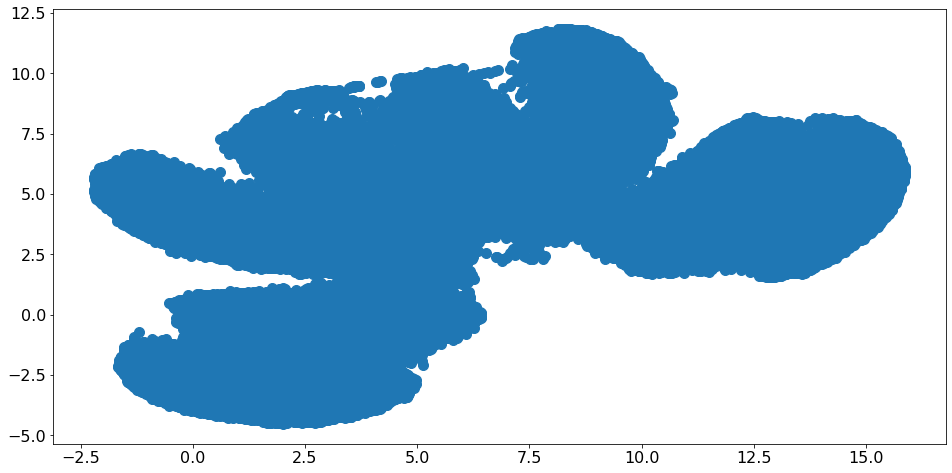

In [353]:
xs = umap_embedding[:, 0]
ys = umap_embedding[:, 1]
ax = plt.scatter(xs, ys)

In [354]:
holdout_meta = metadata[metadata["NAME"].isin(ids)]

In [355]:
full_df = pd.concat([holdout_meta.set_index("NAME"), pca_df, umap_df], axis=1)

In [356]:
col = "MPRA_FXN"
full_df[col] = full_df[col].fillna(-9)
label_map = metadata[col]
cmap = matplotlib.cm.get_cmap("tab20")
color_labels = full_df[col].unique()
pal = sns.color_palette("tab20", len(color_labels))
color_map = dict(zip(color_labels, pal))

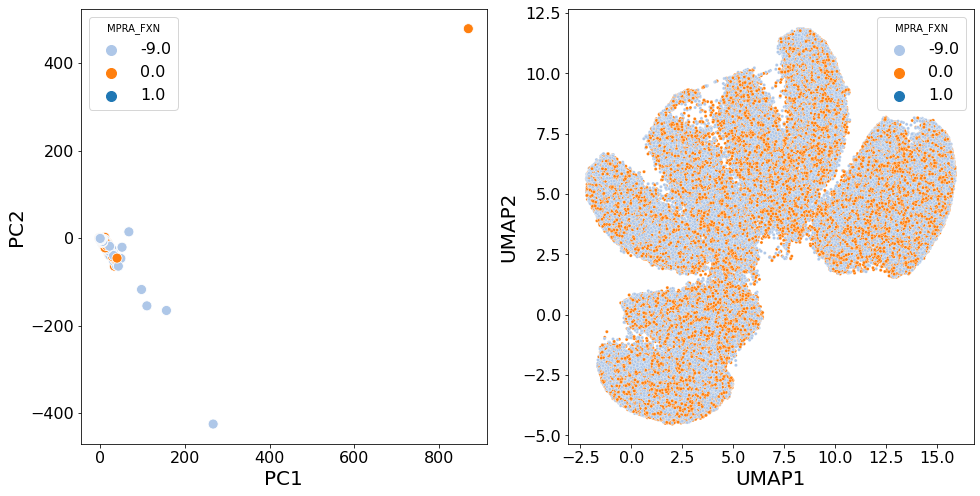

In [359]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))
sns.scatterplot(data=full_df, x="PC1", y="PC2", hue="MPRA_FXN", palette=color_map, ax=ax[0], s=10)
sns.scatterplot(data=full_df, x="UMAP1", y="UMAP2", hue="MPRA_FXN", palette=color_map, ax=ax[1], s=10);

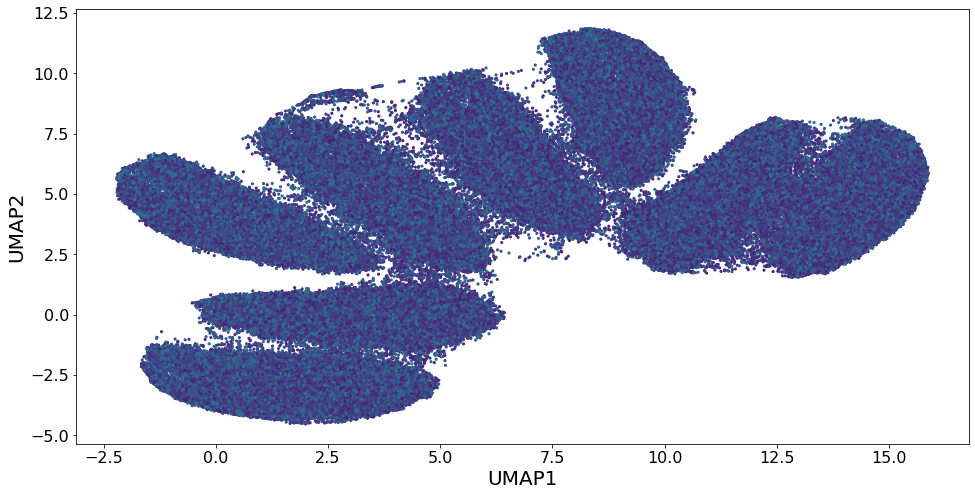

In [358]:
sns.scatterplot(data=full_df, x="UMAP1", y="UMAP2", hue="ACTIVITY_SUMRNA_NUMDNA", palette="viridis", hue_norm=(0, 1), s=10, linewidth=0)
plt.legend([],[], frameon=False);

## Convolutional Filters

In [360]:
pwms = np.load("../results/simple/classification/sscnn/2022_04_23_NPY_Baseline/interpretations/2021_OLS_Libarary_Holdout/pwms.npy")

In [362]:
pwms.shape

(32, 4, 15)

In [363]:
import logomaker as lm

/cellar/users/aklie/opt/miniconda3/envs/pytorch_dev/lib/python3.7/site-packages/logomaker/src/Logo.py:194: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=self.figsize)
/cellar/users/aklie/opt/miniconda3/envs/pytorch_dev/lib/python3.7/site-packages/logomaker/src/Logo.py:194: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=self.figsize)
/cellar/users/aklie/opt/miniconda3/envs/pytorch_dev/lib/python3.7/site-packages/logomaker/src/Logo.py:194: RuntimeWarning: More than 20 figure

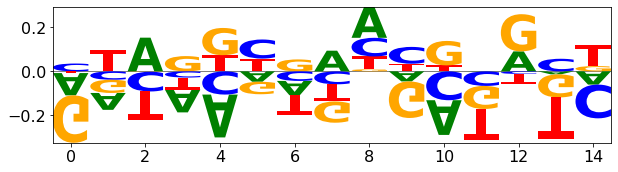

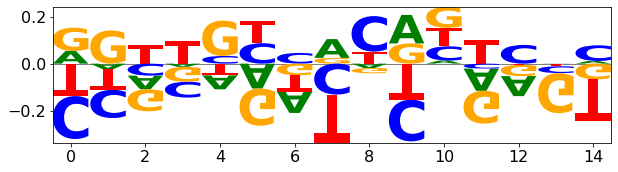

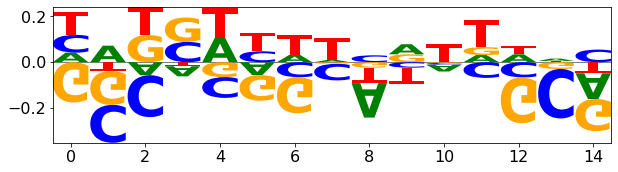

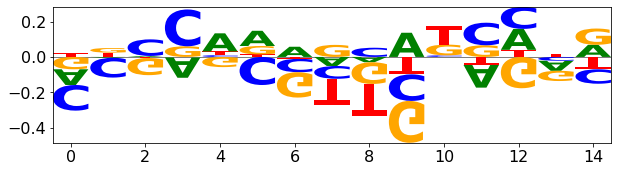

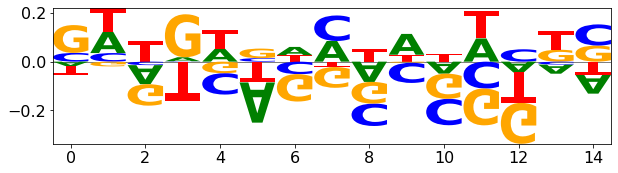

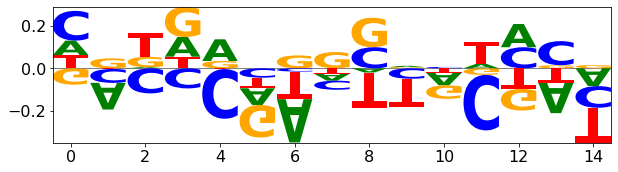

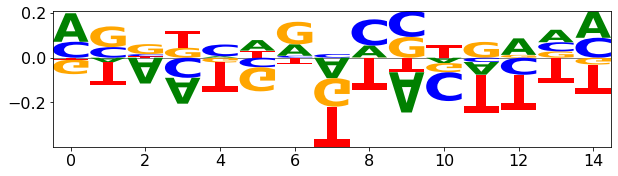

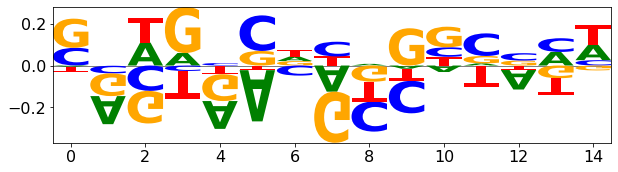

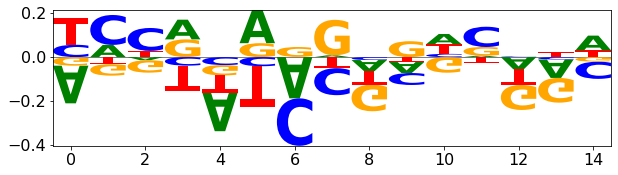

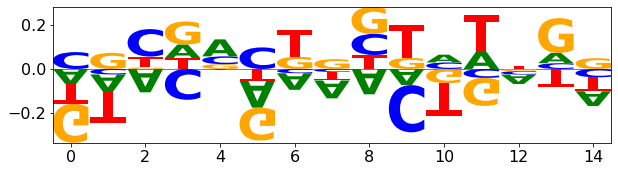

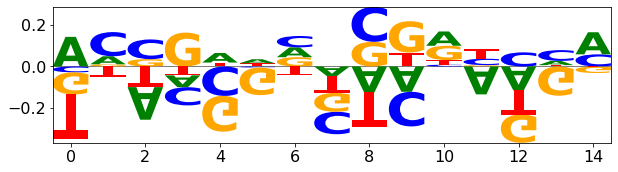

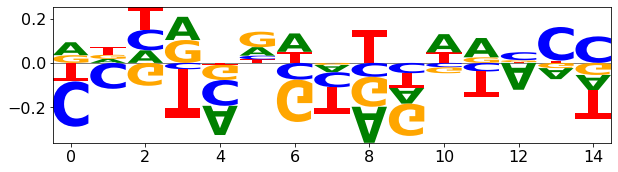

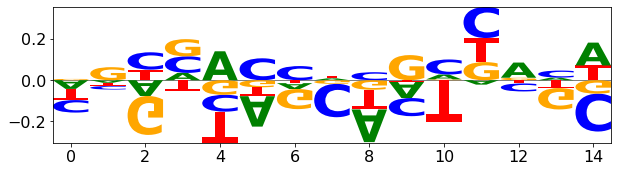

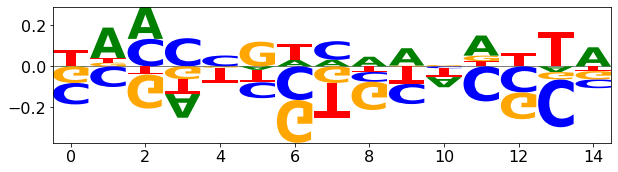

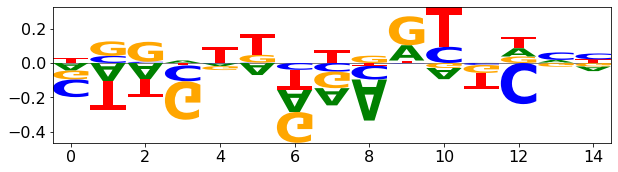

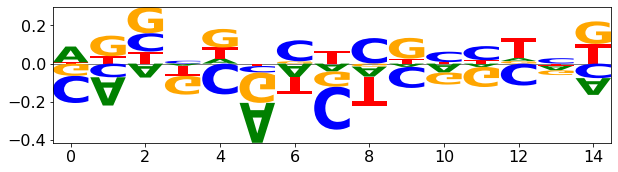

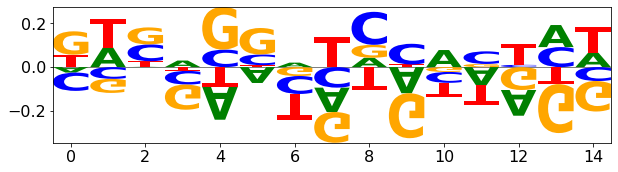

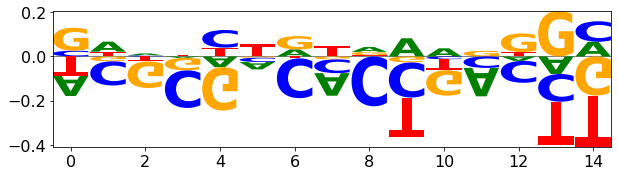

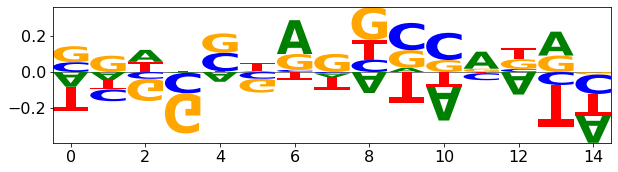

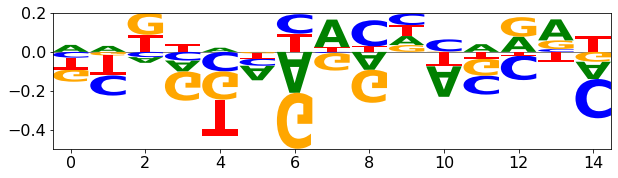

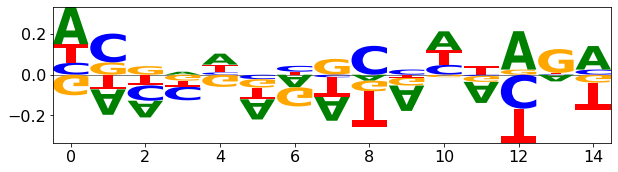

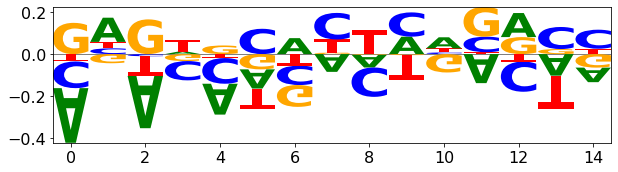

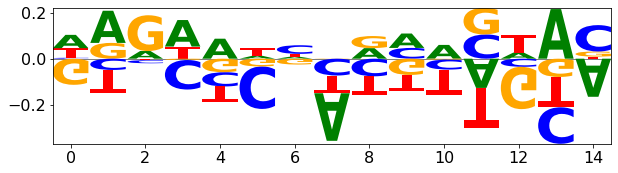

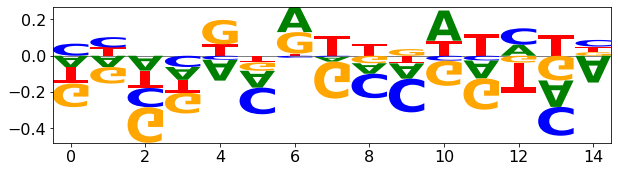

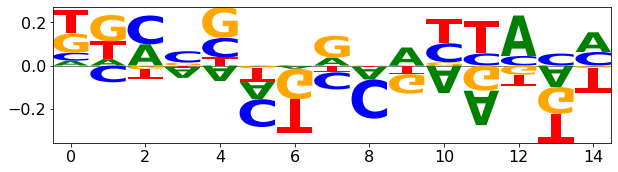

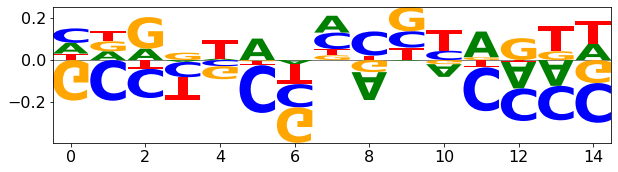

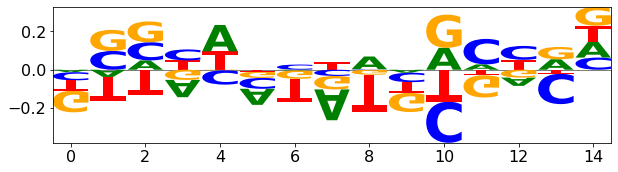

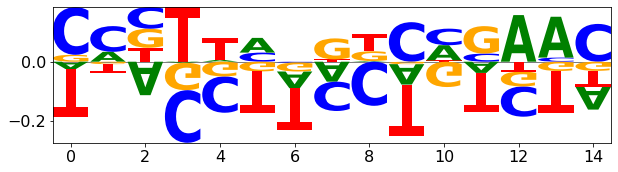

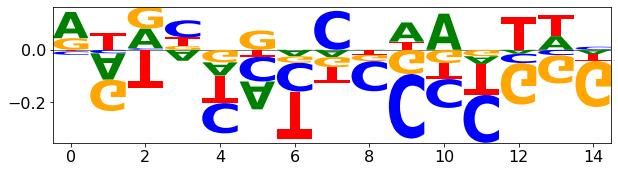

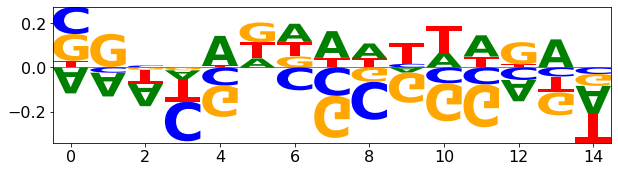

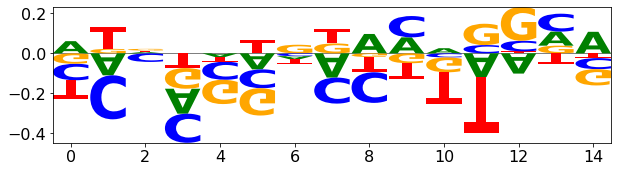

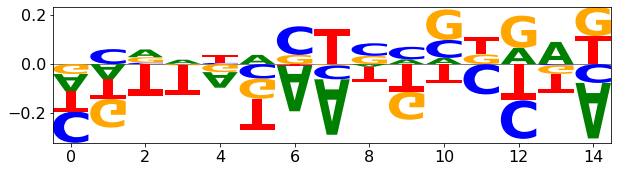

In [368]:
for pwm in pwms:
    pwm_df = pd.DataFrame(columns=["A", "C", "G", "T"], data=pwm.T)
    lm.Logo(pwm_df)

In [369]:
feature_defs

{'S1': 'CATCTGAAGCTC',
 'G1R': 'GTTATCTC',
 'S2': 'TA',
 'E1F': 'ACGGAAGT',
 'S3': 'TTTCGAA',
 'E2F': 'AAGGAAAT',
 'S4': 'TGCTC',
 'G2R': 'AATATCT',
 'S5': '',
 'G3F': 'AAGATAGG',
 'G1F': 'GAGATAAC',
 'E1R': 'ACTTCCGT',
 'E2R': 'ATTTCCTT',
 'G2F': 'AGATATT',
 'G3R': 'CCTATCTT',
 'S6': 'A'}

In [367]:
pwm_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
A,-0.101482,-0.076813,0.153418,-0.103524,-0.194938,-0.047161,-0.065115,0.094165,0.140628,-0.045721,-0.157873,0.001011,0.090994,-0.013485,-0.060138
C,0.035743,-0.038101,-0.090053,-0.028070,-0.105545,0.086954,-0.043415,-0.058860,0.084863,0.076659,-0.131234,-0.066194,-0.011689,0.057408,-0.153567
G,-0.215876,-0.060104,-0.001418,0.069592,0.123784,-0.056899,0.054423,-0.096881,0.009551,-0.166377,0.111231,-0.104750,0.169288,-0.105132,0.024084
T,-0.007615,0.096334,-0.129393,-0.054964,0.073827,0.058167,-0.091238,-0.077855,0.058375,0.034760,0.027313,-0.139987,-0.045447,-0.186923,0.097441


# Scratch
Place for old or testing code

# References